# Evaluation on Dataset 1 with damping term

## Imports (Copy from Synthetic Data Example)

In [1]:
# Cell for personal sys path fixes ...
import sys
sys.path=['', '/opt/local/Library/Frameworks/Python.framework/Versions/2.7/bin', '/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python27.zip', '/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7', '/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/plat-darwin', '/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/plat-mac', '/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/plat-mac/lib-scriptpackages', '/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/lib-tk', '/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/lib-old', '/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/lib-dynload', '/Users/krell/Library/Python/2.7/lib/python/site-packages', '/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages', '/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/aubio-0.4.5a1-py2.7-macosx-10.12-x86_64.egg', '/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/IPython/extensions', '/Users/krell/.ipython']
sys.path.append("/Users/krell/Documents/pyspace")

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import gridspec

import numpy as np
import time
import warnings
warnings.filterwarnings("ignore")
from collections import defaultdict

from sklearn.metrics import r2_score, mean_absolute_error, \
    mean_squared_error, median_absolute_error, explained_variance_score
from sklearn.svm import SVR

from scipy.stats import norm, uniform
from scipy.stats import gaussian_kde
from statsmodels.api import nonparametric
KDEMultivariate = nonparametric.KDEMultivariate
default_KDE = nonparametric.EstimatorSettings(efficient=True)

print "Package Versions:"
import sklearn; print "  scikit-learn:", sklearn.__version__
import scipy; print "  scipy:", scipy.__version__
import statsmodels; print "  statsmodels:", statsmodels.__version__
import numpy; print "  scipy:", numpy.__version__
import matplotlib; print "  matplotlib:", matplotlib.__version__

Package Versions:
  scikit-learn: 0.18.1
  scipy: 0.19.0
  statsmodels: 0.8.0
  scipy: 1.12.1
  matplotlib: 2.0.0


## Import dataset 1 and 3 and map dataset 3 from acceleration to damping term problem

In [13]:
data1 = np.loadtxt('data_1_test_10Hz.csv', delimiter=',')
features1,targets1 = data1[:,0], data1[:,1]
data3 = np.loadtxt('data_r_combined.csv', delimiter=',')
features3 = data3[4000:5000,0]
targets3 = -data3[4000:5000,1]+350*data3[4000:5000, 2]
features3 = data3[:,0]
targets3 = -data3[:,1]+350*data3[:, 2]

## Utility functions

In [4]:
def plot_hist_and_KDE(data, x_grid, xlabel=None):
    """Plot the histogram of the *data* and the respective KDE
    
    The statsmodels KDE is used.
    *x_grid* defines the point used for plotting the function.
    If *xlabel* is provided, it is used as label for the x-axis.
    """
    # larger tick labels needed for plotting in paper
    label_size = 20
    plt.rcParams['xtick.labelsize'] = label_size 
    plt.rcParams['ytick.labelsize'] = label_size 
    fig = plt.figure(figsize=(8,5))
     # "normal_reference" could be used for speed up instead or "cv_ml"
    method = "cv_ls"
    efficient = True
    default_KDE = nonparametric.EstimatorSettings(efficient=efficient)
    t = time.time()
    # Core KDE fitting
    kde = KDEMultivariate(data=[data], var_type='c', 
                          bw=method, defaults=default_KDE)
    density_estimate = kde.pdf(x_grid)
    tf = time.time()
    plt.plot(x_grid, density_estimate, linewidth=3, color="k")
    plt.legend(loc='best')
    # rwidth is required to see the bars.
    plt.hist(data, bins=50, normed=1, histtype="bar", rwidth=0.5)
    if not xlabel is None:
        plt.xlabel(xlabel, fontsize=label_size)

def get_kde(data, x_grid):
    """Extract KDE on data and provide it on x_grid"""
    method = "cv_ls"
    efficient = True
    default_KDE = nonparametric.EstimatorSettings(efficient=efficient)
    kde = KDEMultivariate(data=[data], var_type='c', 
                          bw=method, defaults=default_KDE)
    return kde.pdf(x_grid)

### Copy from example_3.ipynb

In [5]:
def calculate_metrics(act, pred, feat=None, feat_weighting=False, 
                              metrics=None, label=""):
    """Calculate normal regression metrics as well as corrected ones
    
    :returns: metric dictionary with respective keys for the metrics,
        and the weight names that were used for correcting imbalance.
    
    **Parameters**
    
        :act: actual values (list of real values or 1-D array)
        :pred: predicted values (list of real values or 1-D array)
        :feat: original samples as feature vectors
        :feat_weighting: True if weighting should be done by the 
            distribution calculated on *feat* samples instead of *act* 
            samples
        :metrics: dictionary that gets filled with the added metrics.
        :label: Prefix to be added to the metric names, like train/test to
            distinguish between metrics calculated on training or testing 
            data or different components for multivariate evaluation.
    """
    # init
    if metrics is None:
        metrics = defaultdict(float)
    weights_list = [None]
    weights_name = [""]
    if feat_weighting:
        if feat != None:
            weighting_by = feat
        else:
            print "Warning: no features given as input, " + \
                  "weighting by targets.."
            weighting_by = act
    else:
        weighting_by = act

    # Get weights from statspackages
    # other possible methods: "cv_ml" and "normal_reference"
    for method in ["cv_ls"]:
        t = time.time()
        kde = KDEMultivariate(
                data=[weighting_by], var_type='c', bw=method,
                defaults=default_KDE)
        tf = time.time()
        # uses same data for training and generating weights automatically
        inverse_weights = kde.pdf()
        weights_list.append(1.0 / inverse_weights)
        weights_name.append("_" + method)
        print method , "done:", tf-t, " time used" 
    # "silverman" could be also used
    for method in ["scott"]:
        kde = gaussian_kde(weighting_by, method)
        # use same data for training and generating weights
        inverse_weights = kde(weighting_by)
        weights_list.append(1.0 / inverse_weights)
        weights_name.append("_" + method)

    # Only the median metric does not allow for weighting
    metrics[label+"Sklearn_median_absolute_error"] = \
        median_absolute_error(act, pred)
    # Calculate all the metrics for all possible weight corrections
    # (including no weight correction)
    for i in range(len(weights_list)):
        weights = weights_list[i]
        w = weights_name[i]
        # sklearn metrics
        metrics[label+"Sklearn_R2_score"+w] = r2_score(act, pred, weights)
        metrics[label+"Sklearn_explained_variance_score"+w] = \
            explained_variance_score(act, pred, weights)
        metrics[label+"Sklearn_mean_absolute_error"+w] = \
            mean_absolute_error(act, pred, weights)
        metrics[label+"Sklearn_mean_squared_error"+w] = \
            mean_squared_error(act, pred, weights)
        ######################################################## 
        # other standard metrics
        metrics[label+"Mean-squared_error"+w] = \
            np.average((pred-act)**2, weights=weights)
        metrics[label+"Root_mean-squared_error"+w] = \
            np.sqrt(metrics[label+"Mean-squared_error"+w])
        metrics[label+"Mean_absolute_error"+w] = \
            np.average(np.abs(pred-act), weights=weights)
        metrics[label+"Relative_squared_error"+w] = \
            metrics[label+"Mean-squared_error"+w] / np.average((act - 
                        np.average(act, weights=weights))**2, 
                                                       weights=weights)
        metrics[label+"Root_relative_squared_error"+w] = \
            np.sqrt(metrics[label+"Relative_squared_error"+w])
        metrics[label+"Relative_absolute_error"+w] = \
            metrics[label+"Mean_absolute_error"+w] / np.average(np.abs((
                act - np.average(act, weights=weights))), weights=weights)
        cov = np.cov(act, pred, aweights=weights)
        metrics[label+"Correlation_coefficient"+w] = \
            cov[0, 1] / np.sqrt(cov[0, 0] * cov[1, 1])
    return metrics, weights_name

def extract_metrics_multiple(y, y_pred):
    """Calculates lists for the different metrics for each dimension in y
    
    y denotes the actual values and y_pred the predicted samples.

    The six different metric lists are returned as a tuple
    together with the weight names.
    """
    R2,EVS,MSE,MAE,COR,RAE = [],[],[],[],[],[]
    for i in range(0,y.shape[0]):
        metrics, weights_names = calculate_metrics(y[i], y_pred[i])
        R2_i,EVS_i,MSE_i,MAE_i,COR_i,RAE_i = [],[],[],[],[],[]
        for w in weights_names:
            R2_i.append(metrics['Sklearn_R2_score'+w])
            EVS_i.append(metrics['Sklearn_explained_variance_score'+w])
            MAE_i.append(metrics['Sklearn_mean_absolute_error'+w])
            MSE_i.append(metrics['Sklearn_mean_squared_error'+w])
            COR_i.append(metrics['Correlation_coefficient'+w])
            RAE_i.append(metrics['Relative_absolute_error'+w])
        R2.append(R2_i)
        EVS.append(EVS_i)
        MAE.append(MAE_i)
        MSE.append(MSE_i)
        COR.append(COR_i)
        RAE.append(RAE_i)
    return ([R2, EVS, MAE, MSE, COR, RAE],weights_names)

def extract_xmetrics_multiple(y, y_pred, x):
    """Like :func:`extract_metrics_multiple` but with sample based weighting
    
    y denotes the actual values, y_pred the predicted samples, and 
    x the respective original samples which were used to calculate the
    distribution.

    The six different metric lists are returned as a tuple
    together with the weight names.
    """
    R2,EVS,MSE,MAE,COR,RSE = [],[],[],[],[],[]
    for i in range(0,y.shape[0]):
        metrics, weights_names = calculate_metrics(
            y[i], y_pred[i], feat=x[i], feat_weighting=True)
        R2_i,EVS_i,MSE_i,MAE_i,COR_i,RSE_i = [],[],[],[],[],[]
        for w in weights_names:
            R2_i.append(metrics['Sklearn_R2_score'+w])
            EVS_i.append(metrics['Sklearn_explained_variance_score'+w])
            MAE_i.append(metrics['Sklearn_mean_absolute_error'+w])
            MSE_i.append(metrics['Sklearn_mean_squared_error'+w])
            COR_i.append(metrics['Correlation_coefficient'+w])
            RSE_i.append(metrics['Relative_absolute_error'+w])
        R2.append(R2_i)
        EVS.append(EVS_i)
        MAE.append(MAE_i)
        MSE.append(MSE_i)
        COR.append(COR_i)
        RSE.append(RSE_i)
    return ([R2, EVS, MAE, MSE, COR, RSE],weights_names)

## Data distribution dataset 1

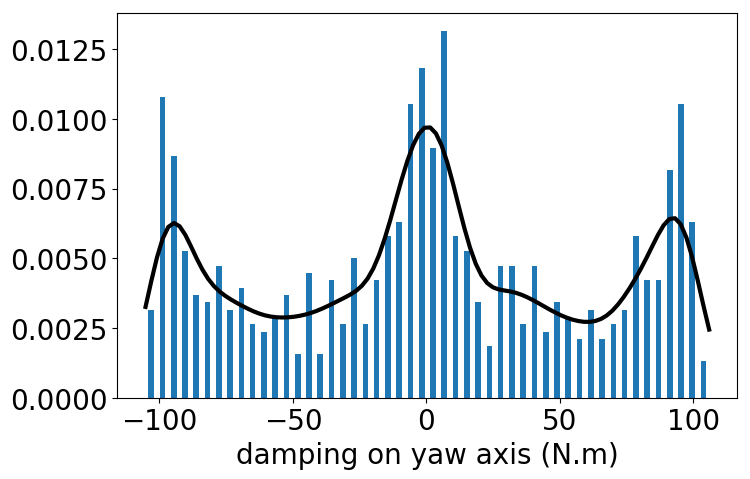

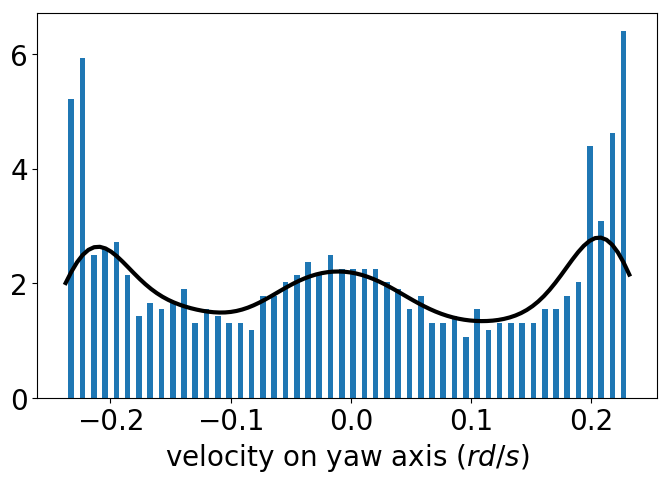

In [24]:
plot_hist_and_KDE(targets1, np.linspace(targets1.min(),targets1.max(),100), 
                  xlabel = 'damping on yaw axis (N.m)')
plot_hist_and_KDE(features1, np.linspace(features1.min(),features1.max(),100),
                  xlabel = 'velocity on yaw axis ($rd/s$)')

## Data distribution dataset 3

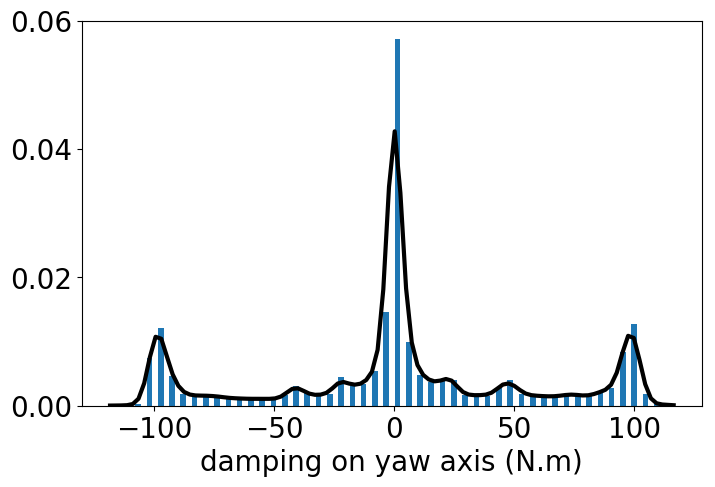

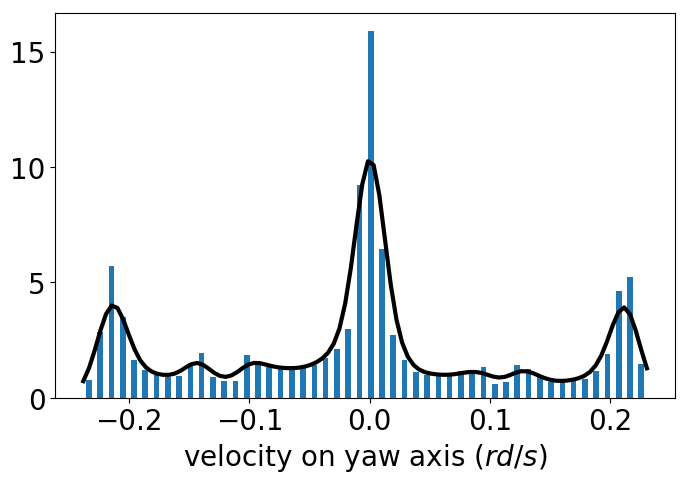

In [23]:
plot_hist_and_KDE(targets3, np.linspace(targets3.min(),targets3.max(),100), 
                  xlabel = 'damping on yaw axis (N.m)')
plot_hist_and_KDE(features3, np.linspace(features3.min(),features3.max(),100),
                  xlabel = 'velocity on yaw axis ($rd/s$)')

## Support Vector Regression

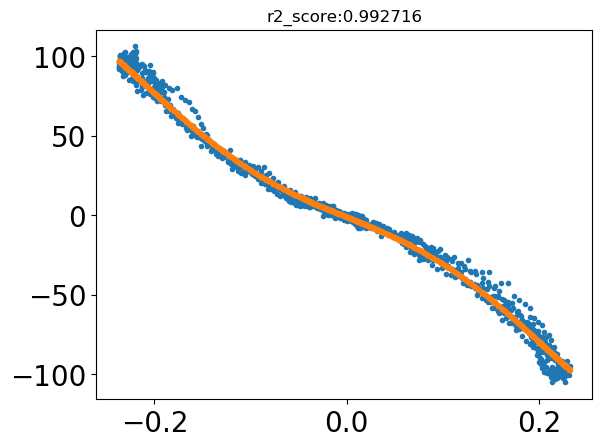

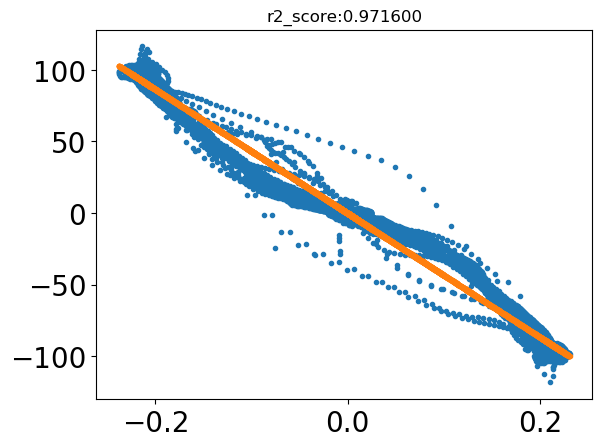

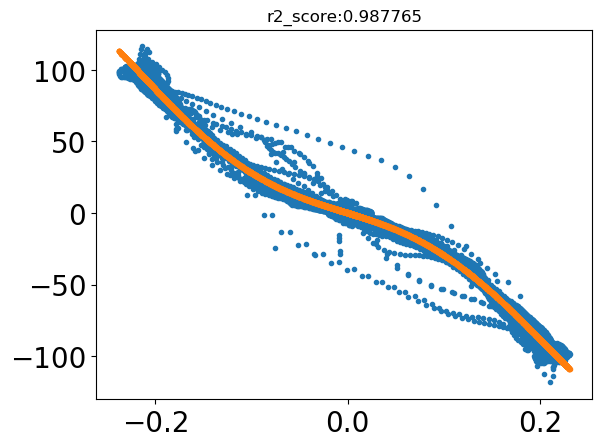

In [26]:
svr1 = SVR(C=10,gamma=10,epsilon=0.1).fit(features1[:,None],targets1)
y1_pred = svr1.predict(features1[:,None])
plt.figure()
plt.plot(features1, targets1,'.')
plt.plot(features1, y1_pred,'.')
plt.title('r2_score:%f' %(r2_score(targets1, y1_pred)))
plt.show()
svr2 = SVR(kernel='linear', C=10,gamma=10,epsilon=0.1).fit(features3[:,None],targets3)
y2_pred = svr2.predict(features3[:,None])
plt.figure()
plt.plot(features3, targets3,'.')
plt.plot(features3, y2_pred,'.')
plt.title('r2_score:%f' %(r2_score(targets3, y2_pred)))
plt.show()
svr3 = SVR(C=10,gamma=10,epsilon=0.1).fit(features3[:,None],targets3)
y3_pred = svr3.predict(features3[:,None])
plt.figure()
plt.plot(features3, targets3,'.')
plt.plot(features3, y3_pred,'.')
plt.title('r2_score:%f' %(r2_score(targets3, y3_pred)))
plt.show()


## Generating Data with Artificial Peaks

First, the data is sorted by the x-values and divided in 5 parts. To generate peaks, the original data is augmented with the data from a single part 5 times. This doubles the dataset size. This process is repeated for every part.

chunk 0
chunk 1
chunk 2
chunk 3
chunk 4


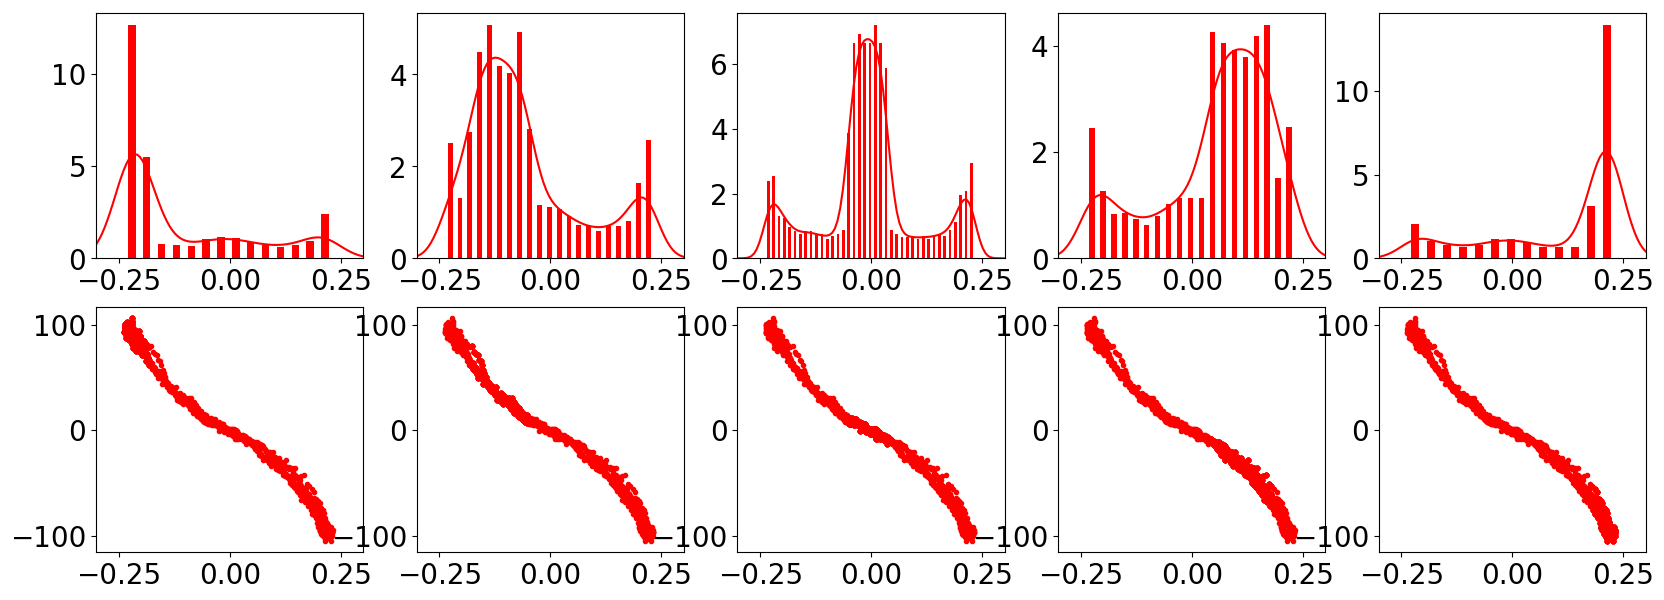

chunk 0
chunk 1
chunk 2
chunk 3
chunk 4


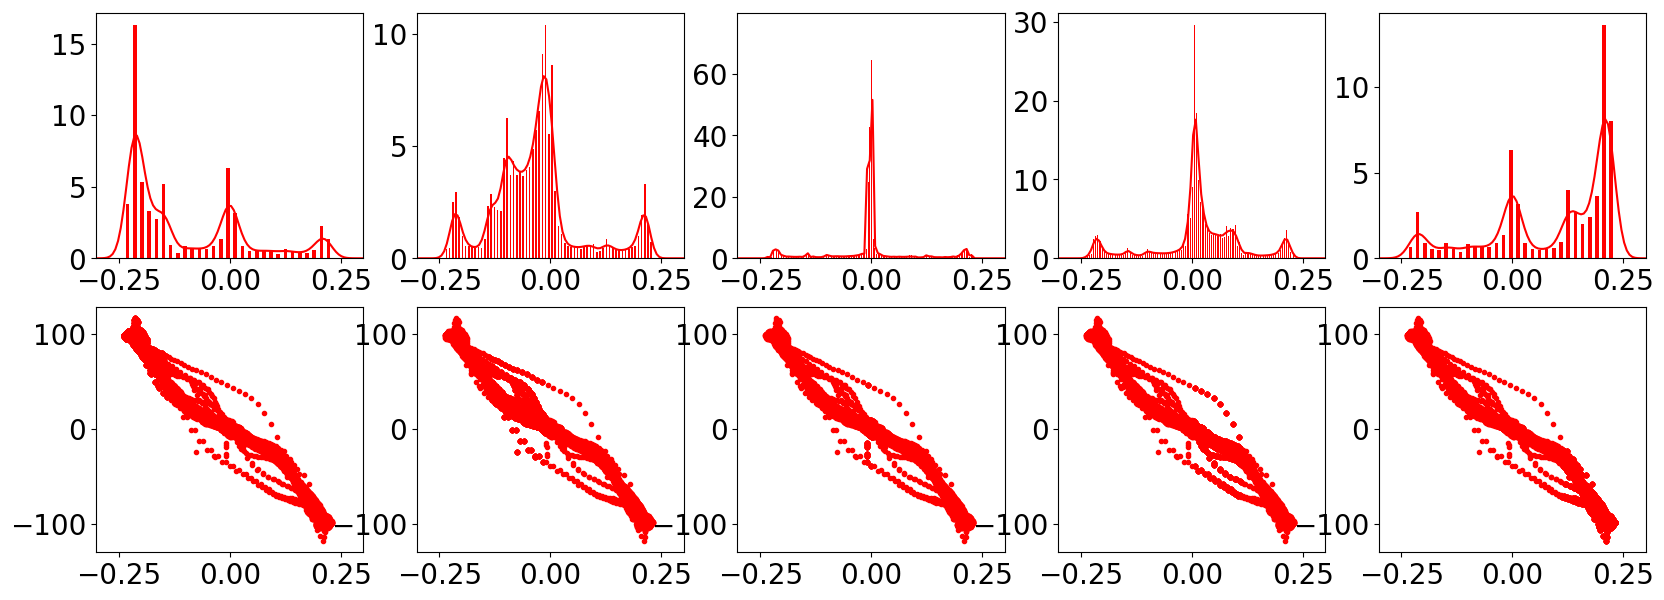

In [17]:
# Sort the data by the sample values
a = zip(features1, targets1)
a.sort()
# targets
t = [i[1] for i in a]
# feature vectors
f = [i[0] for i in a]

# init
bins = 5
l = len(t)
X_plot = np.linspace(-0.3,0.3,100)
n_samples1 = int(2*l)
x = np.zeros((bins, n_samples1)) # samples for each peak
y = np.zeros((bins, n_samples1)) # respective function values

fig, axx = plt.subplots(2, 5, figsize=(20,7))
for i in range(bins):
    print 'chunk %i'%i
    # use original data + data from chunk/bin i
    x[i] = np.concatenate((f, f[i * l / bins:(i + 1) * l / bins] * bins))
    y[i] = np.concatenate((t, t[i * l / bins:(i + 1) * l / bins] * bins))
    density_estimate_i = get_kde(x[i], X_plot)
    axx[0,i].plot(X_plot, density_estimate_i)
    axx[0,i].hist(x[i], bins='fd', normed=1, histtype="bar", rwidth=0.5)
    axx[1,i].plot(x[i],y[i],'.')
    # highlight the modified part (same formula as in concatenate)
    axx[1,i].plot(f[i*l/bins:(i+1)*l/bins]*bins,
                  t[i*l/bins:(i+1)*l/bins]*bins,'.' )
plt.setp(axx, xlim=(-0.301,0.301))
plt.show()

x1 = x
y1 = y

# Sort the data by the sample values
a = zip(features3, targets3)
a.sort()

# Code copy

# targets
t = [i[1] for i in a]
# feature vectors
f = [i[0] for i in a]

# init
bins = 5
l = len(t)
X_plot = np.linspace(-0.3,0.3,100)
n_samples3 = int(2*l)
x = np.zeros((bins, n_samples3)) # samples for each peak
y = np.zeros((bins, n_samples3)) # respective function values

fig, axx = plt.subplots(2, 5, figsize=(20,7))
for i in range(bins):
    print 'chunk %i'%i
    # use original data + data from chunk/bin i
    x[i] = np.concatenate((f, f[i * l / bins:(i + 1) * l / bins] * bins))
    y[i] = np.concatenate((t, t[i * l / bins:(i + 1) * l / bins] * bins))
    density_estimate_i = get_kde(x[i], X_plot)
    axx[0,i].plot(X_plot, density_estimate_i)
    axx[0,i].hist(x[i], bins='fd', normed=1, histtype="bar", rwidth=0.5)
    axx[1,i].plot(x[i],y[i],'.')
    # highlight the modified part (same formula as in concatenate)
    axx[1,i].plot(f[i*l/bins:(i+1)*l/bins]*bins,
                  t[i*l/bins:(i+1)*l/bins]*bins,'.' )
plt.setp(axx, xlim=(-0.301,0.301))
plt.show()

x3 = x
y3 = y

## Calculate metrics

In [27]:
# calculate predictions for each bin with SVR trained 
# on original data for dataset 1
y1i_pred = np.zeros((bins, n_samples1))
for i in range(bins):
    y1i_pred[i] = svr1.predict(x1[i,:][:,None])
# calculate metrics with different weightings
print 'weighting by target density of dataset 1'
metrics1_y, weight_names = extract_metrics_multiple(y1, y1i_pred)
print 'weighting by feature density of dataset 1'
metrics1_x, weight_names = extract_xmetrics_multiple(y1, y1i_pred, x1)

# calculate predictions for each bin with SVR trained 
# on original data for dataset 3
y3i_pred = np.zeros((bins, n_samples3))
for i in range(bins):
    y3i_pred[i] = svr3.predict(x3[i,:][:,None])
# calculate metrics with different weightings
print 'weighting by target density of modified dataset 3'
#metrics3_y, weight_names = extract_metrics_multiple(y3, y3i_pred)
print 'weighting by feature density of modified dataset 3'
#metrics3_x, weight_names = extract_xmetrics_multiple(y3, y3i_pred, x3)

# calculate predictions for each bin with SVR trained 
# on original data for dataset 3
y2i_pred = np.zeros((bins, n_samples3))
for i in range(bins):
    y2i_pred[i] = svr2.predict(x3[i,:][:,None])
# calculate metrics with different weightings
print 'weighting by target density of modified dataset 3'
metrics2_y, weight_names = extract_metrics_multiple(y3, y2i_pred)
print 'weighting by feature density of modified dataset 3'
metrics2_x, weight_names = extract_xmetrics_multiple(y3, y2i_pred, x3)

weighting by target density of dataset 1
cv_ls done: 1.78537082672  time used
cv_ls done: 1.94096899033  time used
cv_ls done: 1.85737895966  time used
cv_ls done: 1.95117306709  time used
cv_ls done: 1.92641019821  time used
weighting by feature density of dataset 1
cv_ls done: 3.38746786118  time used
cv_ls done: 3.2588019371  time used
cv_ls done: 1.1167318821  time used
cv_ls done: 1.19334197044  time used
cv_ls done: 5.77908396721  time used
weighting by target density of modified dataset 3
weighting by feature density of modified dataset 3
weighting by target density of modified dataset 3
cv_ls done: 149.265331984  time used
cv_ls done: 214.299873114  time used
cv_ls done: 339.276543856  time used
cv_ls done: 191.50514698  time used
cv_ls done: 159.899751902  time used
weighting by feature density of modified dataset 3
cv_ls done: 15.4757640362  time used
cv_ls done: 14.4175899029  time used
cv_ls done: 15.79292202  time used
cv_ls done: 14.5795528889  time used
cv_ls done: 17.88

## Visualize x- and y-weighting on both datasets

In [34]:
# Reset plot environment and define colors for plotting
plt.rcParams.update(plt.rcParamsDefault)
from cycler import cycler
plt.rc('axes', prop_cycle=(cycler('color', ['r']*3+['b']*3+['g']*3)))
label_size = 18
plt.rcParams['xtick.labelsize'] = label_size 
plt.rcParams['ytick.labelsize'] = label_size 

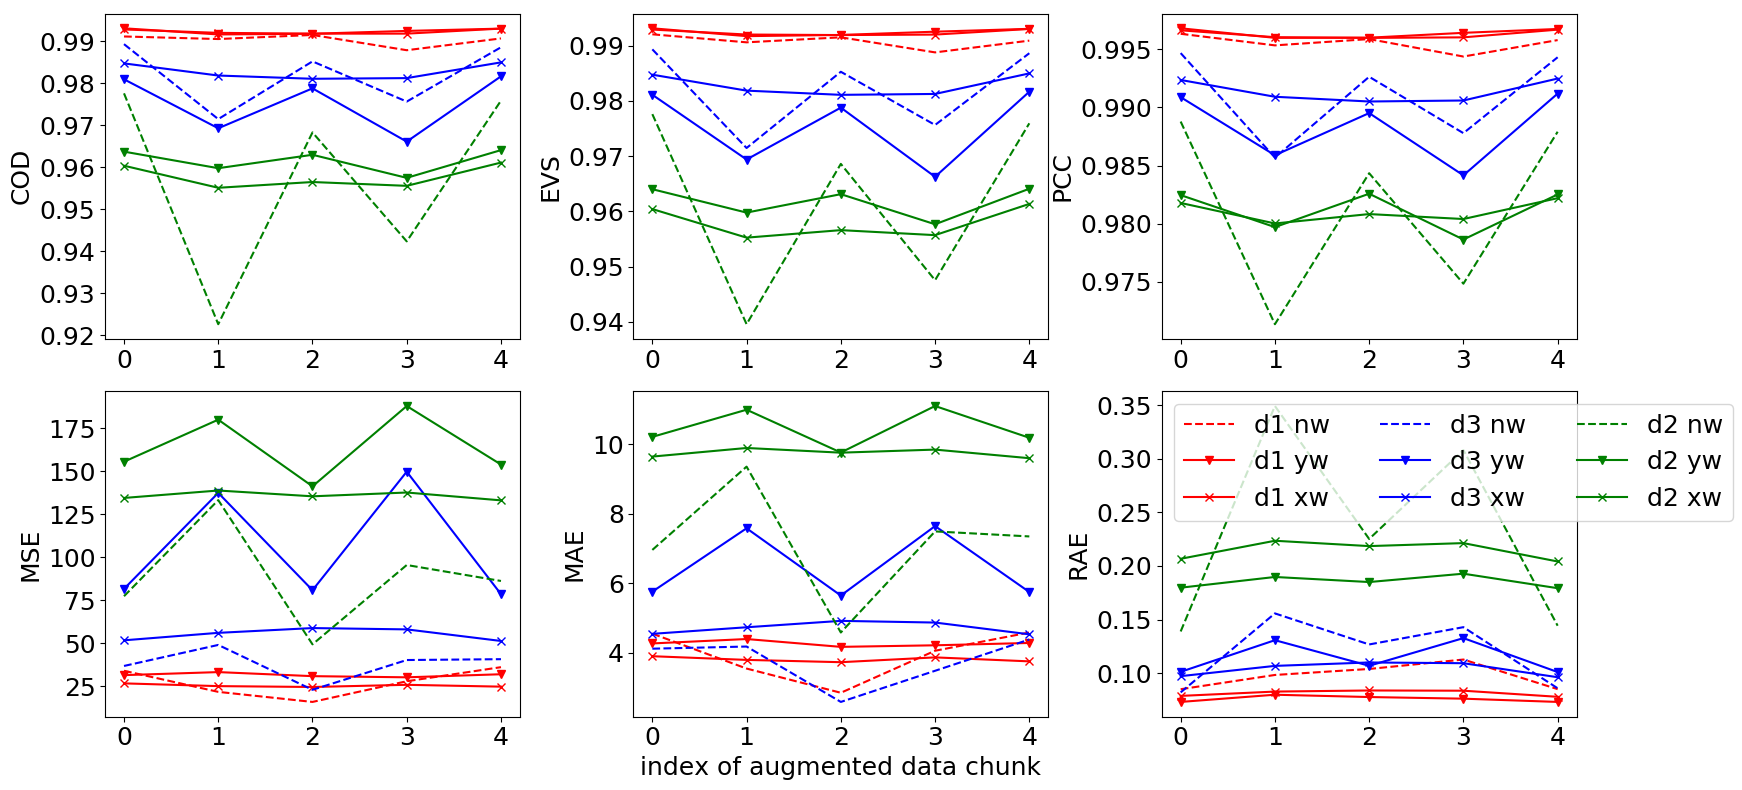

In [35]:
bins = 5
labels = range(bins)

# basically modified code copy from example_3.ipynb
fig, axx = plt.subplots(2, 3, figsize=(16,8))
# no weighting
for R2, EVS, MAE, MSE, COR, RAE in [metrics1_y]:
    axx[0,0].plot(np.array(R2)[:,0],'--') 
    axx[0,0].set_ylabel('COD', fontsize=label_size)
    axx[0,1].plot(np.array(EVS)[:,0],'--')
    axx[0,1].set_ylabel('EVS', fontsize=label_size)
    axx[0,2].plot(np.array(COR)[:,0],'--')
    axx[0,2].set_ylabel('PCC', fontsize=label_size)
    axx[1,0].plot(np.array(MSE)[:,0],'--')
    axx[1,0].set_ylabel('MSE', fontsize=label_size)
    axx[1,1].plot(np.array(MAE)[:,0],'--')
    axx[1,1].set_ylabel('MAE', fontsize=label_size)
    axx[1,1].set_xlabel("index of augmented data chunk", 
                        fontsize=label_size)
    axx[1,2].plot(np.array(RAE)[:,0],'--')
    axx[1,2].set_ylabel('RAE', fontsize=label_size)
# y weighting
for R2, EVS, MAE, MSE, COR, RAE in [metrics1_y]:
    axx[0,0].plot(np.array(R2)[:,1],'-v') 
    axx[0,1].plot(np.array(EVS)[:,1],'-v')
    axx[0,2].plot(np.array(COR)[:,1],'-v')
    axx[1,0].plot(np.array(MSE)[:,1],'-v')
    axx[1,1].plot(np.array(MAE)[:,1],'-v')
    axx[1,2].plot(np.array(RAE)[:,1],'-v')
# x weighting
for R2, EVS, MAE, MSE, COR, RAE in [metrics1_x]:
    axx[0,0].plot(np.array(R2)[:,1],'-x') 
    axx[0,1].plot(np.array(EVS)[:,1],'-x')
    axx[0,2].plot(np.array(COR)[:,1],'-x')
    axx[1,0].plot(np.array(MSE)[:,1],'-x')
    axx[1,1].plot(np.array(MAE)[:,1],'-x')
    axx[1,2].plot(np.array(RAE)[:,1],'-x')
# no weighting
for R2, EVS, MAE, MSE, COR, RAE in [metrics3_y]:
    axx[0,0].plot(np.array(R2)[:,0],'--') 
    axx[0,1].plot(np.array(EVS)[:,0],'--')
    axx[0,2].plot(np.array(COR)[:,0],'--')
    axx[1,0].plot(np.array(MSE)[:,0],'--')
    axx[1,1].plot(np.array(MAE)[:,0],'--')
    axx[1,2].plot(np.array(RAE)[:,0],'--')
# y weighting
for R2, EVS, MAE, MSE, COR, RAE in [metrics3_y]:
    axx[0,0].plot(np.array(R2)[:,1],'-v') 
    axx[0,1].plot(np.array(EVS)[:,1],'-v')
    axx[0,2].plot(np.array(COR)[:,1],'-v')
    axx[1,0].plot(np.array(MSE)[:,1],'-v')
    axx[1,1].plot(np.array(MAE)[:,1],'-v')
    axx[1,2].plot(np.array(RAE)[:,1],'-v')
# x weighting
for R2, EVS, MAE, MSE, COR, RAE in [metrics3_x]:
    axx[0,0].plot(np.array(R2)[:,1],'-x') 
    axx[0,1].plot(np.array(EVS)[:,1],'-x')
    axx[0,2].plot(np.array(COR)[:,1],'-x')
    axx[1,0].plot(np.array(MSE)[:,1],'-x')
    axx[1,1].plot(np.array(MAE)[:,1],'-x')
    axx[1,2].plot(np.array(RAE)[:,1],'-x')
# no weighting
for R2, EVS, MAE, MSE, COR, RAE in [metrics2_y]:
    axx[0,0].plot(np.array(R2)[:,0],'--') 
    axx[0,1].plot(np.array(EVS)[:,0],'--')
    axx[0,2].plot(np.array(COR)[:,0],'--')
    axx[1,0].plot(np.array(MSE)[:,0],'--')
    axx[1,1].plot(np.array(MAE)[:,0],'--')
    axx[1,2].plot(np.array(RAE)[:,0],'--')
# y weighting
for R2, EVS, MAE, MSE, COR, RAE in [metrics2_y]:
    axx[0,0].plot(np.array(R2)[:,1],'-v') 
    axx[0,1].plot(np.array(EVS)[:,1],'-v')
    axx[0,2].plot(np.array(COR)[:,1],'-v')
    axx[1,0].plot(np.array(MSE)[:,1],'-v')
    axx[1,1].plot(np.array(MAE)[:,1],'-v')
    axx[1,2].plot(np.array(RAE)[:,1],'-v')
# x weighting
for R2, EVS, MAE, MSE, COR, RAE in [metrics2_x]:
    axx[0,0].plot(np.array(R2)[:,1],'-x') 
    axx[0,1].plot(np.array(EVS)[:,1],'-x')
    axx[0,2].plot(np.array(COR)[:,1],'-x')
    axx[1,0].plot(np.array(MSE)[:,1],'-x')
    axx[1,1].plot(np.array(MAE)[:,1],'-x')
    axx[1,2].plot(np.array(RAE)[:,1],'-x')
plt.setp(axx, xticks=range(bins), xticklabels = labels)
plt.legend(['d1 nw', 'd1 yw', 'd1 xw', 'd3 nw', 'd3 yw', 'd3 xw','d2 nw', 'd2 yw', 'd2 xw'],
           ncol=3, loc='upper left', fontsize=label_size)
plt.tight_layout()
plt.rcParams.update(plt.rcParamsDefault)

In [18]:
plt.rcParams.update(plt.rcParamsDefault)